# US Energy Time Series

This notebook is based on the initial work by https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/notebook.

This notebook goes further to use climate data as a predictor for energy use.

This work also uses a fully held out test set

Natural Gas Prices From
https://datahub.io/core/natural-gas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('Solarize_Light2')

## Gas Prices

In [2]:
gas_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Energy/gas_daily.csv")
gas_df = gas_df.set_index('Date')
gas_df.index = pd.to_datetime(gas_df.index)

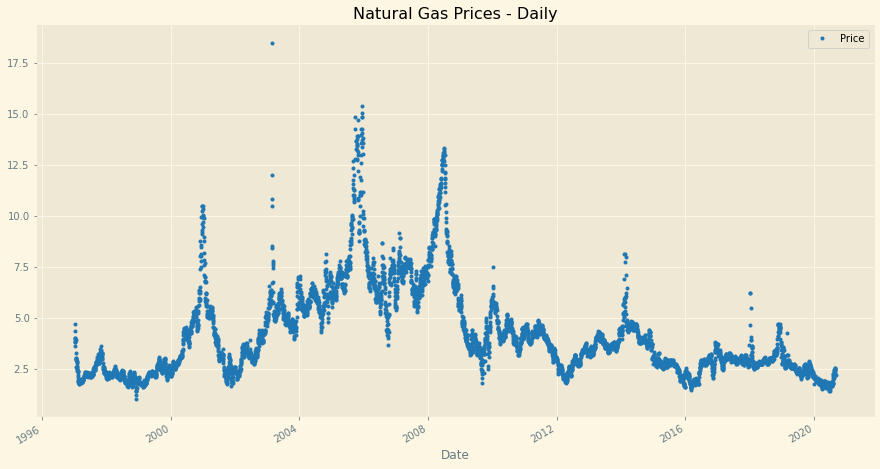

In [3]:
fig, ax = plt.subplots(figsize=(15,8))

gas_df.plot(ax=ax, style=".", color=color_pal[0])
plt.title("Natural Gas Prices - Daily")

plt.show()

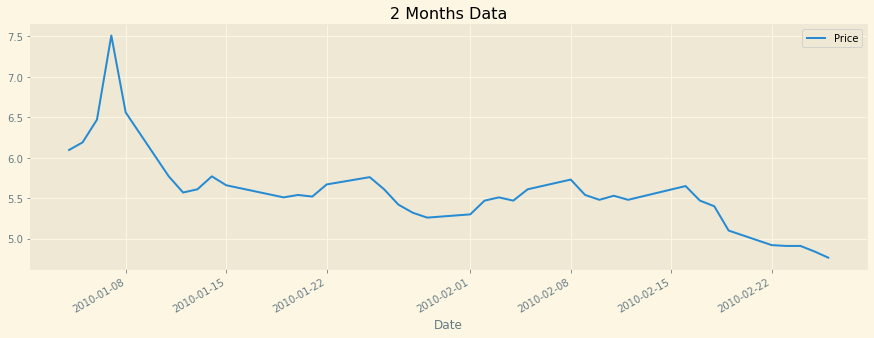

In [4]:
gas_df.loc[(gas_df.index > '01-01-2010') & (gas_df.index < '03-01-2010')] \
    .plot(figsize=(15, 5), title='2 Months Data')
plt.show()

## Energy Use

In [5]:
energy_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Energy/pjm_hourly_est.csv")
energy_df = energy_df.set_index('Datetime')
energy_df.index = pd.to_datetime(energy_df.index)

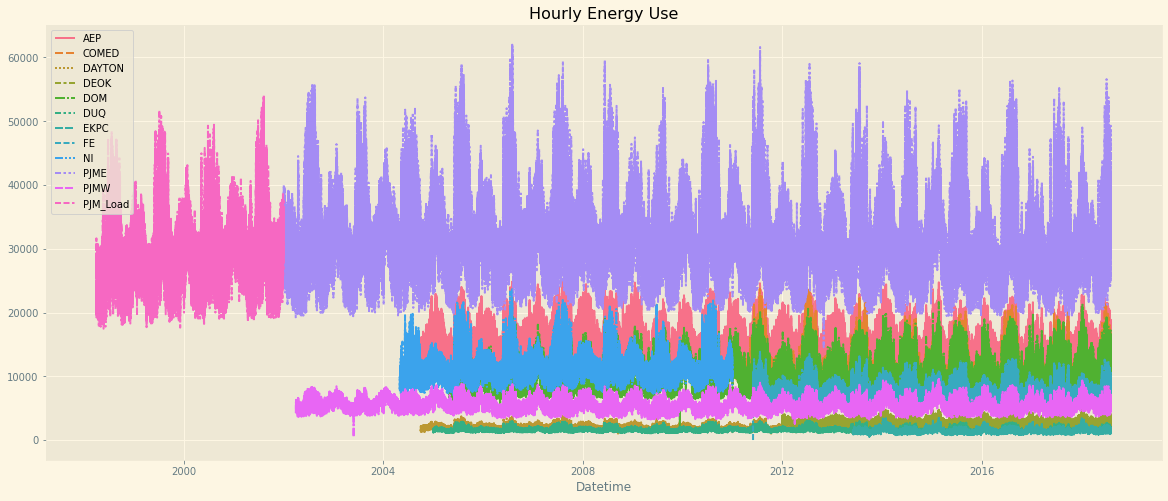

In [6]:
fig, ax = plt.subplots(figsize=(20,8))

#energy_df.plot(ax=ax, color=color_pal[0], style='.')
sns.lineplot(data = energy_df)
plt.title("Hourly Energy Use")

plt.show()

Lets choose to focus on PJME

In [23]:
energy_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Energy/PJME_hourly.csv")
energy_df = energy_df.set_index('Datetime')
energy_df.index = pd.to_datetime(energy_df.index)

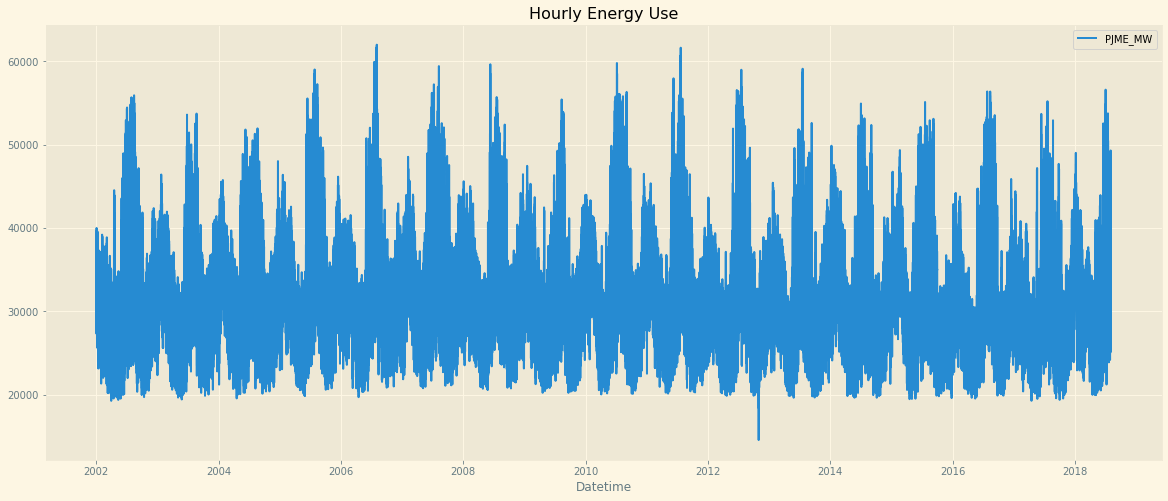

In [8]:
fig, ax = plt.subplots(figsize=(20,8))

#energy_df.plot(ax=ax, color=color_pal[0], style='.')
sns.lineplot(data = energy_df)
plt.title("Hourly Energy Use")

plt.show()

## Climate Data




Import climate data for the area of focus. The PJM [site](https://www.pjm.com/about-pjm/who-we-are/territory-served) says.

> PJM Interconnection coordinates the movement of electricity through all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia and the District of Columbia.

Climate data downloaded from [NOAA](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/46/tavg/all/12/2002-2018?base_prd=true&begbaseyear=2003&endbaseyear=2022)

In [9]:
states = ['OH', 'NC', 'IL', 'MD', 'NJ', 'MI', 'IN', 'KY', 'DE', 'TN', 'WV', 'VA', 'PA']
temp_dfs = {}


for state in states:
    file_str = f"/content/drive/MyDrive/Colab Notebooks/Energy/avg-temp/2002-2018_{state}.csv"
    temp_dfs[state] = pd.read_csv(file_str, header=4)
    temp_dfs[state] = temp_dfs[state].set_index('Date')
    temp_dfs[state].index = pd.to_datetime(temp_dfs[state].index,format="%Y%m")
    temp_dfs[state].columns = [f"{x}_{state}" for x in temp_dfs[state].columns]

    state_temps = pd.concat(temp_dfs.values(), axis=1)

state_temps['Month'] = state_temps.index.to_period("M")

In [10]:
state_temps.head()

,Value_OH,Anomaly_OH,Value_NC,Anomaly_NC,Value_IL,Anomaly_IL,Value_MD,Anomaly_MD,Value_NJ,Anomaly_NJ,...,Anomaly_DE,Value_TN,Anomaly_TN,Value_WV,Anomaly_WV,Value_VA,Anomaly_VA,Value_PA,Anomaly_PA,Month
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,34.1,6.7,42.6,2.5,33.6,7.0,39.0,5.8,36.9,5.9,...,5.6,40.3,2.9,35.0,4.5,39.2,4.1,33.0,7.2,2002-01
2002-02-01,35.0,5.6,44.4,1.3,34.6,5.2,39.8,4.5,38.4,5.2,...,4.5,40.5,-0.3,36.7,3.5,40.5,2.6,33.9,6.1,2002-02
2002-03-01,39.2,-1.0,51.1,0.6,37.8,-4.5,45.4,1.7,42.9,1.8,...,2.1,48.3,-1.9,42.8,0.2,46.3,0.2,38.2,1.3,2002-03
2002-04-01,52.6,1.0,62.5,3.2,53.5,0.3,56.6,2.1,53.9,2.0,...,2.4,60.9,2.1,54.1,1.0,57.7,1.8,50.0,1.3,2002-04
2002-05-01,56.7,-5.2,65.3,-2.0,59.1,-4.7,62.0,-2.0,59.2,-2.7,...,-1.6,64.2,-3.0,57.9,-3.8,62.0,-2.3,55.0,-4.2,2002-05


 Combine the Temperature data with the energy data

In [25]:
energy_df['Month'] = energy_df.index.to_period("M")
energy_df['Datetime'] = energy_df.index
energy_df = pd.merge(left = energy_df, right = state_temps, on="Month", how="left")
energy_df = energy_df.set_index('Datetime')
energy_df

,PJME_MW,Month,Value_OH,Anomaly_OH,Value_NC,Anomaly_NC,Value_IL,Anomaly_IL,Value_MD,Anomaly_MD,...,Value_DE,Anomaly_DE,Value_TN,Anomaly_TN,Value_WV,Anomaly_WV,Value_VA,Anomaly_VA,Value_PA,Anomaly_PA
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12,30.8,-2.3,40.5,-3.8,32.2,0.7,34.3,-4.3,...,36.0,-4.1,39.5,-1.7,32.7,-2.9,36.0,-3.6,27.8,-4.2
2002-12-31 02:00:00,25147.0,2002-12,30.8,-2.3,40.5,-3.8,32.2,0.7,34.3,-4.3,...,36.0,-4.1,39.5,-1.7,32.7,-2.9,36.0,-3.6,27.8,-4.2
2002-12-31 03:00:00,24574.0,2002-12,30.8,-2.3,40.5,-3.8,32.2,0.7,34.3,-4.3,...,36.0,-4.1,39.5,-1.7,32.7,-2.9,36.0,-3.6,27.8,-4.2
2002-12-31 04:00:00,24393.0,2002-12,30.8,-2.3,40.5,-3.8,32.2,0.7,34.3,-4.3,...,36.0,-4.1,39.5,-1.7,32.7,-2.9,36.0,-3.6,27.8,-4.2
2002-12-31 05:00:00,24860.0,2002-12,30.8,-2.3,40.5,-3.8,32.2,0.7,34.3,-4.3,...,36.0,-4.1,39.5,-1.7,32.7,-2.9,36.0,-3.6,27.8,-4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018-01,25.0,-2.4,35.9,-4.2,24.1,-2.5,31.0,-2.2,...,32.8,-1.6,32.9,-4.5,27.0,-3.5,31.8,-3.3,23.1,-2.7
2018-01-01 21:00:00,43751.0,2018-01,25.0,-2.4,35.9,-4.2,24.1,-2.5,31.0,-2.2,...,32.8,-1.6,32.9,-4.5,27.0,-3.5,31.8,-3.3,23.1,-2.7
2018-01-01 22:00:00,42402.0,2018-01,25.0,-2.4,35.9,-4.2,24.1,-2.5,31.0,-2.2,...,32.8,-1.6,32.9,-4.5,27.0,-3.5,31.8,-3.3,23.1,-2.7


## Train Test Split
Same code as in RM

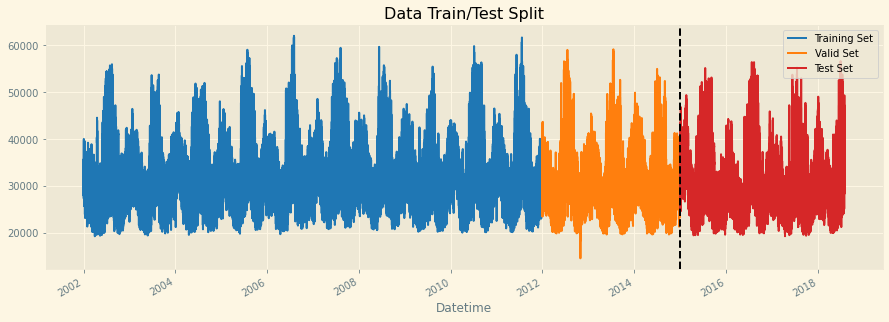

In [32]:
train = energy_df.loc[energy_df.index < '01-01-2012']
valid = energy_df.loc[(energy_df.index >= '01-01-2012') & (energy_df.index < '01-01-2015')]
test = energy_df.loc[energy_df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y ='PJME_MW', ax=ax, label='Training Set', title='Data Train/Test Split', color=color_pal[0])
valid.plot(y ='PJME_MW', ax=ax, label='Valid Set', color=color_pal[1])
test.plot(y ='PJME_MW', ax=ax, label='Test Set', color=color_pal[3])
ax.axvline('01-01-2015', color='black', ls='--')
#ax.legend(['Training Set', 'Valid Set', 'Test Set'])
plt.show()

## Create Features

Cell taken from https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/notebook

In [29]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

energy_df = create_features(energy_df)

Similiar analysis to RM

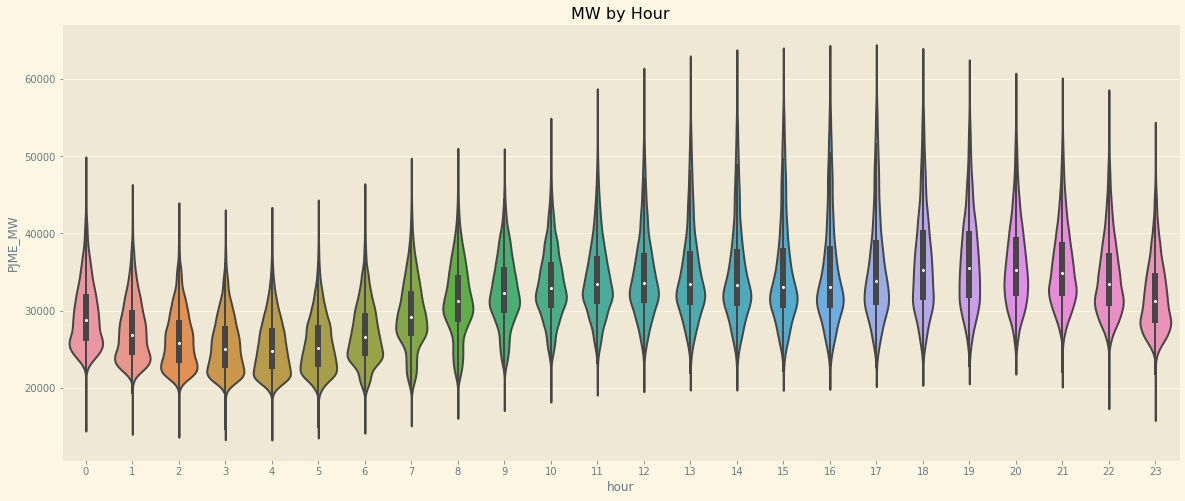

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=energy_df, x="hour", y="PJME_MW")

ax.set_title('MW by Hour')
plt.show()

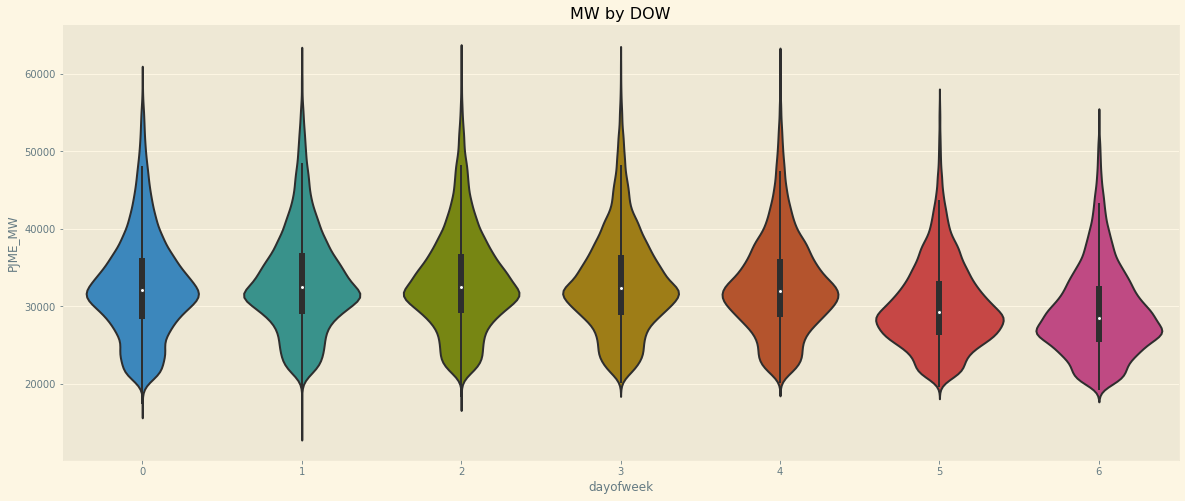

In [18]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=energy_df, x="dayofweek", y="PJME_MW")

ax.set_title('MW by DOW')
plt.show()

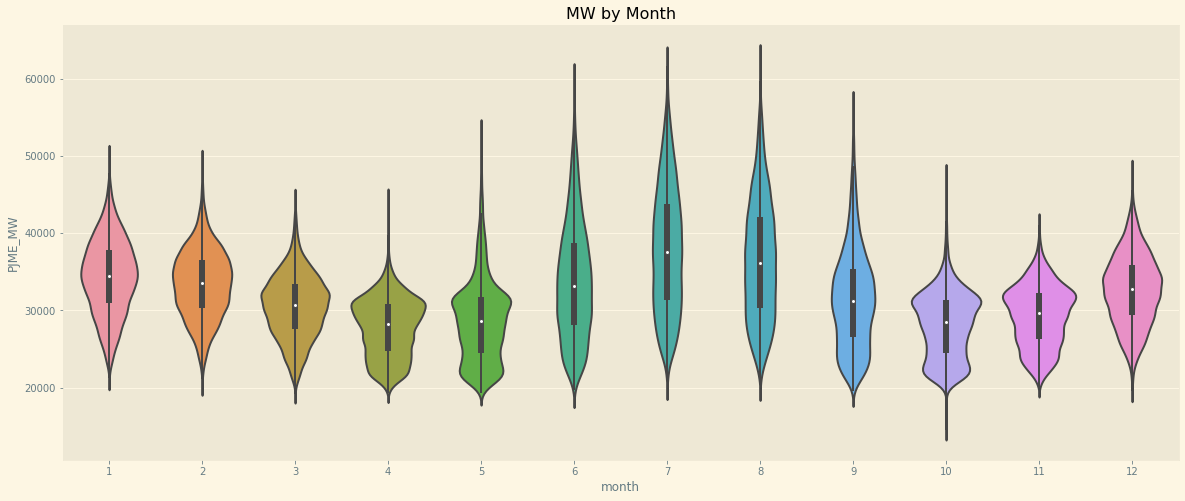

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.violinplot(data=energy_df, x="month", y="PJME_MW")

ax.set_title('MW by Month')
plt.show()

## Create Model

In [34]:
def create_model(features, target):
    X_train = train[features]
    y_train = train[target]

    X_valid = valid[features]
    y_valid = valid[target]

    #X_test = test[features]
    #y_test = test[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
        
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=100)
    
    return reg

In [44]:
train = create_features(train)
valid = create_features(valid)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

reg = create_model(FEATURES,TARGET)

[0]	validation_0-rmse:32826.6	validation_1-rmse:31846.2
[100]	validation_0-rmse:12649.8	validation_1-rmse:11733
[200]	validation_0-rmse:5826.82	validation_1-rmse:5164.65
[300]	validation_0-rmse:3884.63	validation_1-rmse:3694.39
[400]	validation_0-rmse:3403.9	validation_1-rmse:3551.62
[500]	validation_0-rmse:3237.21	validation_1-rmse:3547.93
[600]	validation_0-rmse:3149.2	validation_1-rmse:3534.91
[700]	validation_0-rmse:3092.39	validation_1-rmse:3524.69
[800]	validation_0-rmse:3050.3	validation_1-rmse:3508.66
[900]	validation_0-rmse:3018.58	validation_1-rmse:3499.92
[999]	validation_0-rmse:2983.26	validation_1-rmse:3495.95


In [45]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year'] + [x for x in train.columns if "Value" in x]
TARGET = 'PJME_MW'

reg_temp = create_model(FEATURES,TARGET)

[0]	validation_0-rmse:32824.6	validation_1-rmse:31843.2
[100]	validation_0-rmse:12521.9	validation_1-rmse:11724.1
[200]	validation_0-rmse:5586.65	validation_1-rmse:5111.53
[300]	validation_0-rmse:3611.72	validation_1-rmse:3588.8
[400]	validation_0-rmse:3145.75	validation_1-rmse:3405.69
[500]	validation_0-rmse:3002.57	validation_1-rmse:3399.11
[600]	validation_0-rmse:2935.58	validation_1-rmse:3385.8
[700]	validation_0-rmse:2891.98	validation_1-rmse:3369.75
[800]	validation_0-rmse:2858.73	validation_1-rmse:3350.48
[900]	validation_0-rmse:2830.02	validation_1-rmse:3334.58
[999]	validation_0-rmse:2799.74	validation_1-rmse:3320.96


## Feature Importance

In [46]:
def importance_bar(reg):

    fig, ax = plt.subplots(figsize=(20, 8))

    fi = pd.DataFrame(data=reg.get_booster().get_score(importance_type="gain").values(),
                index=reg.get_booster().get_score(importance_type="gain").keys(),
                columns=['importance'])

    fi.sort_values('importance').plot(kind='barh', title='Feature Importance', ax=ax)

    plt.show()

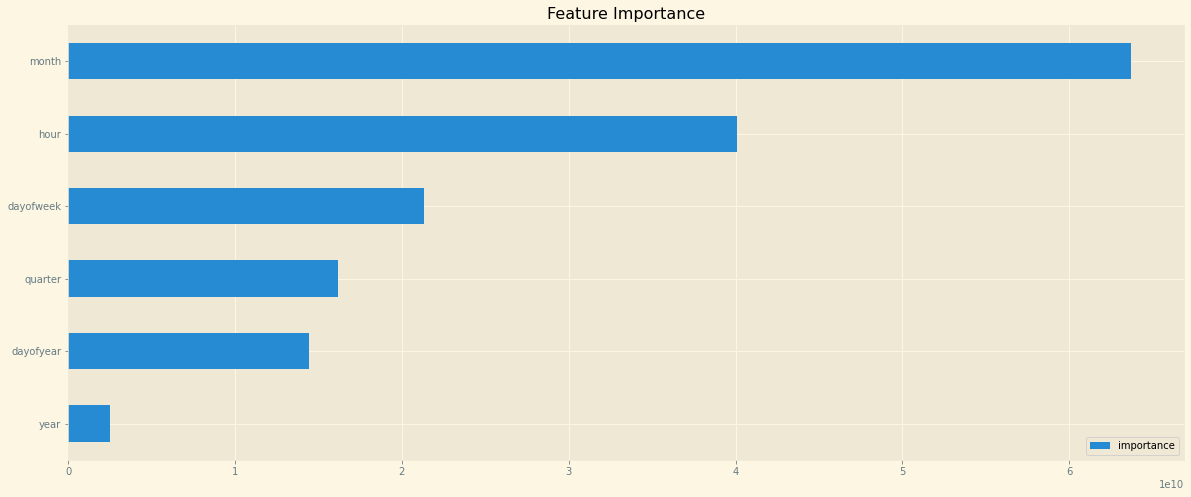

In [47]:
importance_bar(reg)

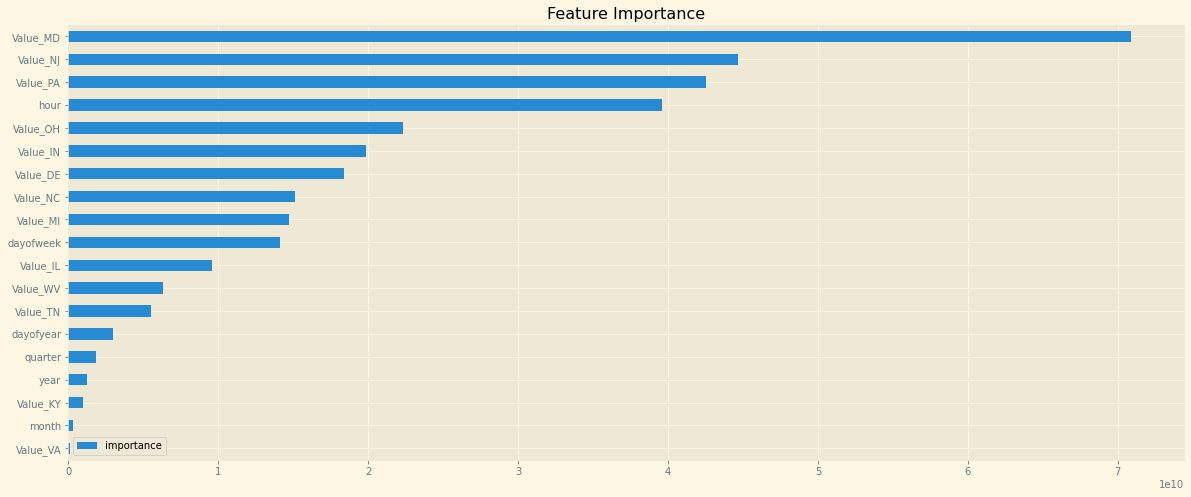

In [48]:
importance_bar(reg_temp)

It appears that we get slightly better prediction when we use statewide temperatures. We also see that the temperature model sees month as less important. This could suggest that temperature better captures the long term variation which month factors can capture.